In [1]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import lightning as pl

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

In [3]:
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

from lightning.pytorch.loggers import TensorBoardLogger
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from tqdm.auto import tqdm

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
pl.seed_everything(1234)

Seed set to 1234


1234

In [7]:
df = pd.read_csv("news_summary.csv", encoding="latin-1")
df.head()

author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujana-...   
4  http://indiatoday.intoday.in/story/sex-traffic...   

                                                text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [8]:
df = df[['text', 'ctext']]
df.head()

text  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                               ctext  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [9]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

summary  \
0  The Administration of Union Territory Daman an...   
1  Malaika Arora slammed an Instagram user who tr...   
2  The Indira Gandhi Institute of Medical Science...   
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4  Hotels in Maharashtra will train their staff t...   

                                                text  
0  The Daman and Diu administration on Wednesday ...  
1  From her special numbers to TV?appearances, Bo...  
2  The Indira Gandhi Institute of Medical Science...  
3  Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4  Hotels in Mumbai and other Indian cities are t...

In [10]:
df.shape

(4396, 2)

In [11]:
train_df, test_df = train_test_split(df, test_size=0.1)
print(f"Shape of the Train Set: {train_df.shape}\nShape of the Test Set: {test_df.shape}")

Shape of the Train Set: (3956, 2)
Shape of the Test Set: (440, 2)


In [12]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, text_max_token_len=512, summary_max_token_len=128):
    
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, index):
        
        data_row = self.data.iloc[index]
        text = data_row["text"]

        text_encoding = self.tokenizer(
            text, 
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        summary_encoding = self.tokenizer(
            data_row["summary"], 
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100
        
        return {
            'text': text,
            'summary': data_row['summary'],
            'text_input_ids': text_encoding['input_ids'].flatten(),
            'text_attention_mask': text_encoding['attention_mask'].flatten(),
            'labels': labels.flatten(),
            'labels_attention_mask': summary_encoding["attention_mask"].flatten()
        }

In [13]:
class NewsDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df,
                 test_df,
                 tokenizer,
                 batch_size=8,
                 text_max_token_len=152,
                 summary_max_token_len=128):
      
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def setup(self, stage=None):
       
        self.train_dataset = NewsDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
        
        self.test_dataset = NewsDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
    
    def train_dataloader(self):
        
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
    
    def test_dataloader(self):
        
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
      
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

In [14]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [15]:
text_token_counts = [len(tokenizer.encode(row["text"])) for _, row in train_df.iterrows()]
summary_token_counts = [len(tokenizer.encode(row["summary"])) for _, row in train_df.iterrows()]

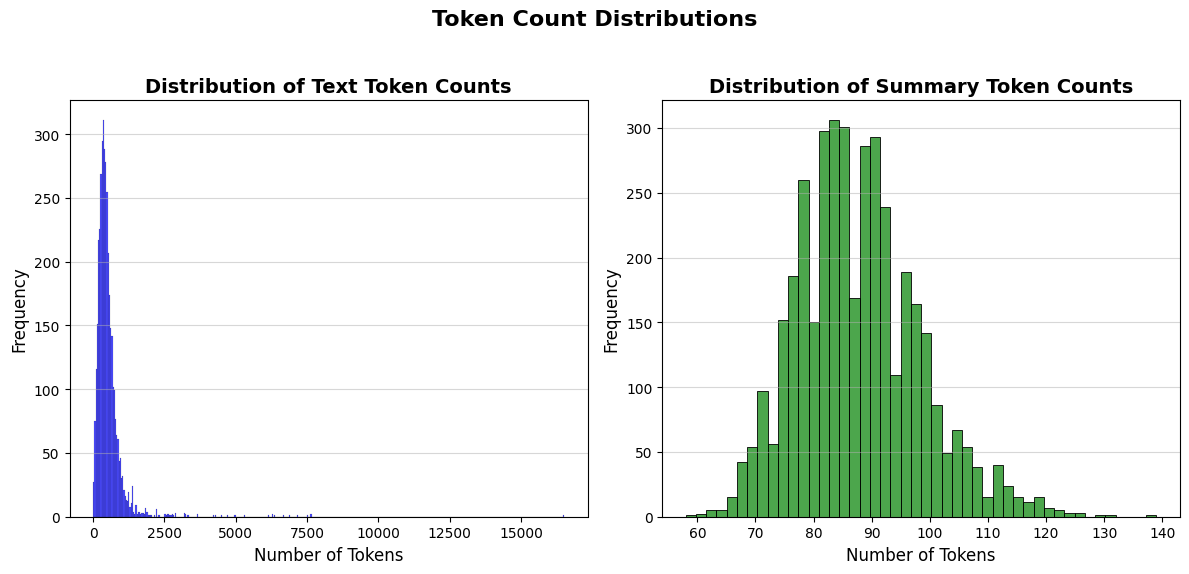

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(text_token_counts, ax=ax1, color='blue', alpha=0.7)
ax1.set_title("Distribution of Text Token Counts", fontsize=14, fontweight='bold')
ax1.set_xlabel("Number of Tokens", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.grid(axis='y', alpha=0.5)

sns.histplot(summary_token_counts, ax=ax2, color='green', alpha=0.7)
ax2.set_title("Distribution of Summary Token Counts", fontsize=14, fontweight='bold')
ax2.set_xlabel("Number of Tokens", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.grid(axis='y', alpha=0.5)

plt.suptitle("Token Count Distributions", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
N_EPOCHS = 1
BATCH_SIZE=8

data_module = NewsDataModule(
    train_df, 
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE
    
)

In [18]:
class SummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits

    def shared_step(self, batch, batch_idx, stage):
        input_ids = batch['text_input_ids']
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, _ = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [19]:
model_1 = SummaryModel()

In [20]:
%load_ext tensorboard
%tensorboard --logdir /Users/aadya/Desktop

Launching TensorBoard...

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
callbacks = ModelCheckpoint(
    dirpath="/Users/aadya/Desktop",
    filename="base-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name="news_summary")

trainer= Trainer(
    logger=logger,
    callbacks=callbacks,
    max_epochs=N_EPOCHS,
    accelerator='gpu', devices=1
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
import os

In [23]:
trainer.fit(model_1, data_module)

Missing logger folder: lightning_logs/news_summary
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/aadya/Desktop exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M  | eval
------------------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 495/495 [04:53<00:00,  1.68it/s, v_num=0, train_loss=1.650, val_loss=1.780]

Epoch 0, global step 495: 'val_loss' reached 1.78488 (best 1.78488), saving model to '/Users/aadya/Desktop/base-checkpoint.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 495/495 [04:56<00:00,  1.67it/s, v_num=0, train_loss=1.650, val_loss=1.780]


In [24]:
import pickle 
with open('pickle_checkpoint.pickle', 'rb') as handle:
    best_model = pickle.load(handle)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.Byte

In [25]:
def encode_text(text):
    encoding = tokenizer.encode_plus(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding["input_ids"], encoding["attention_mask"]

def generate_summary(input_ids, attention_mask):
    generated_ids = best_model.model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    return generated_ids

def decode_summary(generated_ids):
    summary = [tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
               for gen_id in generated_ids]
    return "".join(summary)

def summarize(text):
    input_ids, attention_mask = encode_text(text)
    generated_ids = generate_summary(input_ids, attention_mask)
    summary = decode_summary(generated_ids)
    return summary

In [26]:
sample_row = test_df.iloc[3]
text = sample_row["text"]
model_summary = summarize(text)

In [27]:
text

'New Delhi, Dec 23 (PTI) Prices of over 50 essential drugs including those used for treatment of HIV infection, diabetes, anxiety disorders, bacterial infections, angina and acid reflux have been capped by the government, leading to a price cut in the range of 5 per cent to 44 per cent. The National Drug Pricing Regulator has also fixed the retail prices of 29 formulations. "NPPA has fixed/revised ceiling prices of 55 scheduled formulations of Schedule-I under Drugs (Price Control) Amendment Order,2016 and retail price of 29 formulations under DPCO, 2013 in related Notification /order dated 23.12.2016," National Pharmaceutical Pricing Authority (NPPA) said in a statement. On being contacted about the price reduction, NPPA Chairman Bhupendra Singh told PTI: "The prices have been reduced in the range of 5 to 44 per cent, with the average being about 25 per cent". As stipulated under the Drugs (Prices Control) Order (DPCO) 2013, NPPA fixes ceiling price of essential medicines of Schedule 

In [28]:
sample_row["summary"]

'The prices of about 50 drugs, including those used for treatment of HIV infection, diabetes, and bacterial infections, have been capped by the government, leading to a price cut in the range of 5-44%. In respect of medicines not under price control, manufacturers are allowed by the National Drug Pricing Regulator to increase the maximum retail price by 10% annually.'

In [29]:
model_summary

'The National Pharmaceutical Pricing Authority (NPPA) has capped the retail prices of over 50 essential drugs, including those used for treatment of HIV infection, diabetes, anxiety disorders, bacterial infections, angina and acid reflux. "The prices have been reduced in the range of 5% to 44%, with the average being about 25%," said NPPA Chairman Bhupendra Singh.'